In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd
import os

In [7]:
rootdir = '/lcncluster/lisboa/spikes_audio_diffusion/experiment/data'
files = os.listdir(rootdir)
pilot_files = ["data_pilot.csv"]
for i,f in enumerate(files):
    if f in pilot_files:
        files.pop(i)
print(files)
infiles = [rootdir + '/'+f for f in files]


['data.csv']


In [8]:
frames = [pd.read_csv(infile) for infile in infiles]
df = pd.concat(frames, ignore_index= True)
#print(df)

/tmp/ipykernel_101431/16472014.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(infile) for infile in infiles]


In [9]:
columns = [["Participant Private ID",
            "Response Type",
            "Response",
            "Component Name",
            "Object Name",
            "Spreadsheet: display",
            "Spreadsheet: reference",
            "Spreadsheet: subset"]]
columns.append([f'Spreadsheet: compressed{i}' for i in range(1,6)])
columns  = [c for lc in columns for c in lc]
print(columns)

['Participant Private ID', 'Response Type', 'Response', 'Component Name', 'Object Name', 'Spreadsheet: display', 'Spreadsheet: reference', 'Spreadsheet: subset', 'Spreadsheet: compressed1', 'Spreadsheet: compressed2', 'Spreadsheet: compressed3', 'Spreadsheet: compressed4', 'Spreadsheet: compressed5']


In [10]:
df = df[columns]
'''
db = pd.DataFrame()
db["sliders"] = df['Component Name'] == 'Slider' 
db["ratings"] = df['Component Name'] ==  "Rating Scale"
db["or"] = db["sliders"] or db["ratings"]
print(db)

'''
#df = df[df['Component Name'] == 'Slider']

'\ndb = pd.DataFrame()\ndb["sliders"] = df[\'Component Name\'] == \'Slider\' \ndb["ratings"] = df[\'Component Name\'] ==  "Rating Scale"\ndb["or"] = db["sliders"] or db["ratings"]\nprint(db)\n\n'

In [11]:
def get_model_name(instr):    
    if instr[:-11] == '':
        return instr[:-4]
    else: 
        return instr[:-12]
def is_congruent(score,rating):
    ratings = ["Bad","Poor","Fair","Good","Excellent"]
    ind = score // 20
    if ind == 5:
        ind = 4
    return ratings[ind] == rating
def is_valid(sample_data):
    ref = (sample_data['reference']['rating'] == 'Excellent'  and sample_data['reference']['congruent'])
    anc = (sample_data['anchor']['rating'] == 'Bad'  and sample_data['anchor']['congruent'])
    return ref and anc

In [7]:
indices = list(df.index.values)
data = {}


for i, name in enumerate(df["Object Name"]):
    pid = df["Participant Private ID"][indices[i]]
    if np.isnan(pid):
        continue
    else:
        pid = int(pid)
        if pid not in data.keys():
            data[pid] = {}
        
    if df['Spreadsheet: display'][indices[i]] == 'trial':
        block = df['Spreadsheet: subset'][indices[i]] 
        if block not in data[pid].keys():
            data[pid][block] = {}
        sample = get_model_name(df['Spreadsheet: reference'][indices[i]])
        if sample not in data[pid][block].keys():
            data[pid][block][sample] = {}        
            
        if df['Component Name'][indices[i]] in ["Slider", "Rating Scale"]:
            compressed_idx = name[-1]
            compressed = "Spreadsheet: compressed"+compressed_idx   
            model = get_model_name(df[compressed][indices[i]])
            if model == sample:
                model = 'reference'
            if model not in data[pid][block][sample].keys():
                data[pid][block][sample][model] = {} 
            
            if df['Component Name'][indices[i]] == 'Slider':
                score = int(df["Response"][indices[i]])
                data[pid][block][sample][model]['score'] = score
            else:
                data[pid][block][sample][model]['rating'] = df["Response"][indices[i]]
            
            if len(data[pid][block][sample][model].keys()) == 2:
                score = data[pid][block][sample][model]['score']
                rating = data[pid][block][sample][model]['rating']
                data[pid][block][sample][model]["congruent"] = is_congruent(score, rating)
                
    elif df['Spreadsheet: display'][indices[i]] == 'questionaire':
        if df['Object Name'][indices[i]] == "Music Rating":
            data[pid]['music'] = df["Response"][indices[i]]
        elif df['Object Name'][indices[i]] == "Headphone Rating":
            data[pid]['headphones'] = df["Response"][indices[i]]

for pid in data.keys():
    for block in data[pid].keys():
        if block not in ['music','headphones']:
            for sample in data[pid][block].keys():
                valid = is_valid(data[pid][block][sample])
                data[pid][block][sample]['valid'] = valid
          

for p in data.keys():
    print('\n')
    print(p)
    for b in data[p].keys():
        if b not in ['music','headphones']:
            print(b)
            print(data[p][b])



8754181
FTq
{'audio_1': {'FREE': {'score': 57, 'rating': 'Fair', 'congruent': True}, 'RVQ_50': {'score': 25, 'rating': 'Poor', 'congruent': True}, 'anchor': {'score': 5, 'rating': 'Bad', 'congruent': True}, 'reference': {'score': 100, 'rating': 'Excellent', 'congruent': True}, 'SPARSE': {'score': 43, 'rating': 'Fair', 'congruent': True}, 'valid': True}}
QMq
{'audio_7': {'reference': {'score': 100, 'rating': 'Excellent', 'congruent': True}, 'RVQ': {'score': 42, 'rating': 'Fair', 'congruent': True}, 'MEL': {'score': 30, 'rating': 'Poor', 'congruent': True}, 'anchor': {'score': 3, 'rating': 'Bad', 'congruent': True}, 'RVQ_50': {'score': 32, 'rating': 'Poor', 'congruent': True}, 'valid': True}}
TMq
{'audio_8': {'RVQ_50': {'score': 18, 'rating': 'Bad', 'congruent': True}, 'reference': {'score': 100, 'rating': 'Excellent', 'congruent': True}, 'MEL': {'score': 28, 'rating': 'Poor', 'congruent': True}, 'anchor': {'score': 2, 'rating': 'Bad', 'congruent': True}, 'SPARSE': {'score': 35, 'ratin

In [16]:
sdata = {}
sdata['pids'] = []
sdata['music'] = []
sdata['headphones'] = []


for pid in data.keys():
    sdata['pids'].append(pid)
    for k in ["music","headphones"]:
        sdata[k].append(data[pid][k])


    

In [17]:
def sort_dict(m):
    models = {"reference": 0,
              "anchor": 1,
              "RVQ":2,
              "FREE":3,
              "SPARSE":4,
              "MEL":5,
              "RVQ_50":6,
             }
    if m in models.keys():
        return models[m]
    else: 
        return 100
def sift_shitty_headphones(k):
    return k not in ['0$-50$']
    
adata = {}
for p in data.keys(): #participants
    for b in data[p].keys(): #blocks QFT, QFM,QFq ...
        cond = sift_shitty_headphones(data[p]['headphones'])
        if b not in ['music','headphones'] and cond:
            for s in data[p][b].keys(): # samples audio_1,audio_3...
                if s not in adata.keys():
                    adata[s] = {} 
                valid = data[p][b][s]['valid']
                for m in data[p][b][s].keys():
                    if m not in ['valid'] and valid:
                        if m not in adata[s].keys():                            
                            adata[s][m] = {'score':[],'rating':[],'congruent':[]}
                        for k in adata[s][m].keys():
                            adata[s][m][k].append(data[p][b][s][m][k]) 
                adata[s] = dict(sorted(adata[s].items(),key = lambda i: sort_dict(i[0])))
Mdata = {}
for p in data.keys(): #participants
    for b in data[p].keys(): #blocks QFT, QFM,QFq ...
        cond = sift_shitty_headphones(data[p]['headphones'])
        if b not in ['music','headphones'] and cond:
            for s in data[p][b].keys(): # samples audio_1,audio_3...
                valid = data[p][b][s]['valid']
                for m in data[p][b][s].keys():
                    if m not in ['valid'] and valid:
                        if m not in Mdata.keys():                            
                            Mdata[m] = {'score':[],'rating':[],'congruent':[]}                            
                        for k in Mdata[m].keys():
                            Mdata[m][k].append(data[p][b][s][m][k])   
Mdata = dict(sorted(Mdata.items(),key = lambda i: sort_dict(i[0])))



In [18]:
# Colapse data over participants
bdata = {}
for p in data.keys(): #participants
    for b in data[p].keys(): #blocks QFT, QFM,QFq ...
        #Sifting Out Shitty headphones
        cond = sift_shitty_headphones(data[p]['headphones'])
        if b not in ['music','headphones'] and cond:
            if b not in bdata.keys():
                bdata[b] = {}
            for s in data[p][b].keys(): # samples audio_1,audio_3...
                if s not in bdata[b].keys():
                    bdata[b][s] = {}
                
                #COMMENT THE SECOND PART OF THIS LINE TO SIFT OUT INVALID RATINGS
                if data[p][b][s]['valid']:# or not data[p][b][s]['valid']:
                    for m in data[p][b][s].keys(): #models reference,quant...
                        if m != 'valid':
                            if m not in bdata[b][s].keys():
                                bdata[b][s][m] = {'score': [], 'rating':[], 'congruent':[],'pids':[]}
                            for k in data[p][b][s][m].keys():
                                bdata[b][s][m][k].append(data[p][b][s][m][k])
                            bdata[b][s][m]['pids'].append(p)
                bdata[b][s] = dict(sorted(bdata[b][s].items(),key = lambda i: sort_dict(i[0])))


wins = {}                
for b in bdata.keys():
    for s in bdata[b].keys():
        for m1 in bdata[b][s].keys():
            if m1 not in wins.keys():
                wins[m1] = {}
            for m2 in bdata[b][s].keys(): 
                if m2 not in wins[m1].keys():
                    wins[m1][m2] = [0,0]   
                scores1 = bdata[b][s][m1]['score']
                scores2 = bdata[b][s][m2]['score']
                
                for s1,s2 in zip(scores1,scores2):
                    if m1 == m2:
                        wins[m1][m2][0] += 1
                        wins[m1][m2][1] += 1                        
                    else:
                        if s1>s2:    
                            wins[m1][m2][0] +=1                                
                        wins[m1][m2][1] += 1
                            
                    
                
            #print(f"{m1}: {bdata[b][s][m1]}")
wins = dict(sorted(wins.items(),key = lambda i: sort_dict(i[0])))
for w in wins.keys():
    wins[w] = dict(sorted(wins[w].items(),key = lambda i: sort_dict(i[0])))

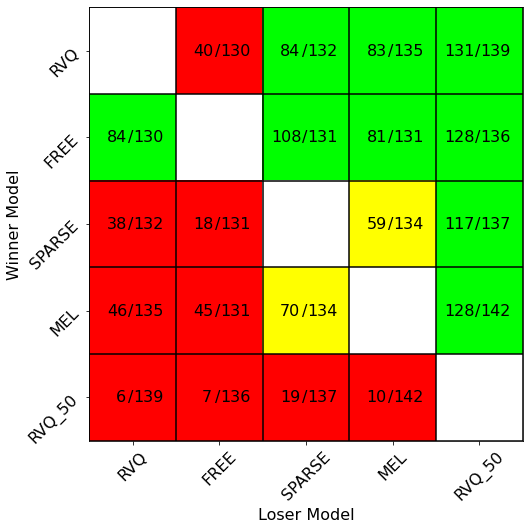

In [21]:
def digits(num):
    if num ==0:
        return 1
    count = 0
    while num != 0:
        num //= 10
        count += 1
    return count
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = [(1.,0.,0.),(1,1,0),(0.,1.,0.)]
cmap = LinearSegmentedColormap.from_list('reg_green', colors, N=21)
cmap.set_bad(color = 'w')
keylist = list(wins.keys())[2:]
n = len(keylist)
fig,ax = plt.subplots(figsize=(8,8))
fs = 16
winMat = np.zeros((n,n))

for I,m in enumerate(keylist):
    for J,mm in enumerate(keylist):
        w = wins[m][mm][0]
        t = wins[m][mm][1]
        p = w/t
        ndt = digits(t)
        ndw = digits(w)        
        #Check if a tie is within the confidence interval
        
        var = 1.96*np.sqrt(p*(1-p)/t)
        if 0.5<(p - var): # Loss-> color red
            win = 1
        elif 0.5>(p + var): # Win-> color green
            win = 0.
        else:
            win = 0.5 # Tie -> color white
        
        if I == J:
            annot = "1"
            win = np.nan
            #ax.annotate(annot,(J-0.05,I+0.05),fontsize = fs)
        else:
            annot = f"{int(w)}/{int(t)}"
            #annot = f"{''}/{int(t)}"
            a_slash = "/"
            a_t = f"{int(t)}"
            a_w = f"{int(w)}"
            
            ax.annotate(a_slash,(J-0.05,I+0.05),fontsize = fs)
            ax.annotate(a_t,(J+0.01,I+0.05),fontsize = fs)
            ax.annotate(a_w,(J-0.1-0.1*ndw,I+0.05),fontsize = fs)
            
            
        winMat[I][J] = win
    print('\n')
im = ax.imshow(winMat,cmap=cmap)

ax.set_xticks(range(n), rotation=45,fontsize = fs)
ax.set_xticklabels(keylist, rotation=45,fontsize = fs)
ax.set_yticks(range(n), rotation=45,fontsize = fs)
ax.set_yticklabels(keylist, rotation=45,fontsize = fs)
ax.set_xlabel("Loser Model",fontsize = fs)
ax.set_ylabel("Winner Model",fontsize = fs)
ax.set_xlim([-0.51,n-0.49])
ax.set_ylim([n-0.49,-0.51])

for i in range(n+1):
    ax.axvline(x=-0.5+i,color='k')
    ax.axhline(y=-0.5+i,color='k')
    
#fig.colorbar(im,ax = ax)
#plt.savefig(f'images/wins_goodheadphones.svg',transparent = True)
plt.show()



{'Intermediate': 34, 'Elementary': 33, 'None': 12, 'Advanced': 12, 'Expert': 0}
{'None': 12, 'Elementary': 33, 'Intermediate': 34, 'Advanced': 12, 'Expert': 0}


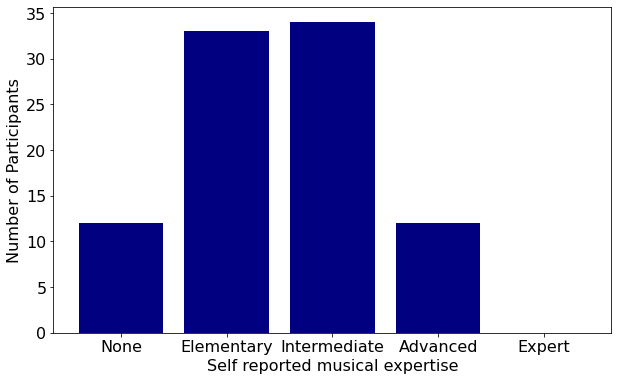

In [20]:
def sorted_music(level):
    levels = {"None": 0, 
              "Elementary": 1, 
              "Intermediate": 2, 
              "Advanced": 3,
              "Expert": 4}
    return levels[level]
fs = 16
music_cts = {x: sdata['music'].count(x) for x in sdata['music']}
music_cts['Expert'] = 0
print(music_cts)
music_cts = {k: v for k, v in music_cts.items() if pd.notna(k)} #Remove NaNs and other errors
music_cts= dict(sorted(music_cts.items(), key = lambda i: sorted_music(i[0]))) #Sort dict
print(music_cts)
fig,ax = plt.subplots(1, figsize = (10,6))
ax.bar(list(music_cts.keys()),music_cts.values(),color = 'navy')
ax.set_xlabel("Self reported musical expertise",fontsize = fs)
ax.set_ylabel("Number of Participants",fontsize = fs)
ax.xaxis.set_tick_params(labelsize =fs)
ax.yaxis.set_tick_params(labelsize=fs)

plt.savefig(f'images/music_level.svg',transparent = True)


{'50$-100$': 25, '0$-50$': 36, '100$-200$': 23, '200$-500$': 7}


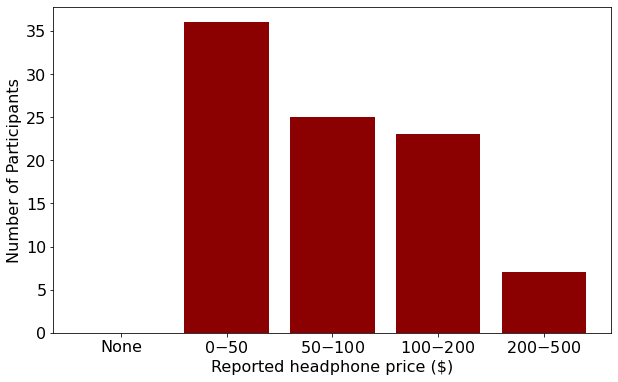

In [13]:
def sorted_headphones(price):
    prices = {"None": -1,
              "0$-50$": 0, 
              "50$-100$": 1, 
              "100$-200$": 2, 
              "200$-500$": 3,
              ">500$": 4}
    return prices[price]
headphone_cts = {x: sdata['headphones'].count(x) for x in sdata['headphones']}
print(headphone_cts)
headphone_cts['None'] = 0
headphone_cts = {k: v for k, v in headphone_cts.items() if pd.notna(k)} #Remove NaNs and other errors
headphone_cts= dict(sorted(headphone_cts.items(), key = lambda i: sorted_headphones(i[0]))) #Sort dict

fig,ax = plt.subplots(1, figsize = (10,6))
ax.bar(list(headphone_cts.keys()),headphone_cts.values(),color = 'darkred')
ax.set_xlabel("Reported headphone price ($)",fontsize = fs)
ax.set_ylabel("Number of Participants",fontsize = fs)
ax.xaxis.set_tick_params(labelsize =fs)
ax.yaxis.set_tick_params(labelsize=fs)

plt.savefig(f'images/headphones.svg',transparent = True)


# Plotting the ratings

reference 93.49253731343283 0.20293994228311904
anchor 2.8276797829036635 0.12427695240232824
RVQ 63.284424379232505 0.8507557863262021
FREE 67.54691075514874 0.9769218513465592
SPARSE 51.075 0.9100521196817192
MEL 57.63844393592677 0.9691416573766586
RVQ_50 32.93392070484582 0.6955541805669084


[Text(0.0, 0, 'reference'),
 Text(0.5, 0, 'anchor'),
 Text(1.0, 0, 'RVQ'),
 Text(2.0, 0, 'FREE'),
 Text(3.0, 0, 'SPARSE'),
 Text(4.0, 0, 'MEL'),
 Text(5.0, 0, 'RVQ_50')]

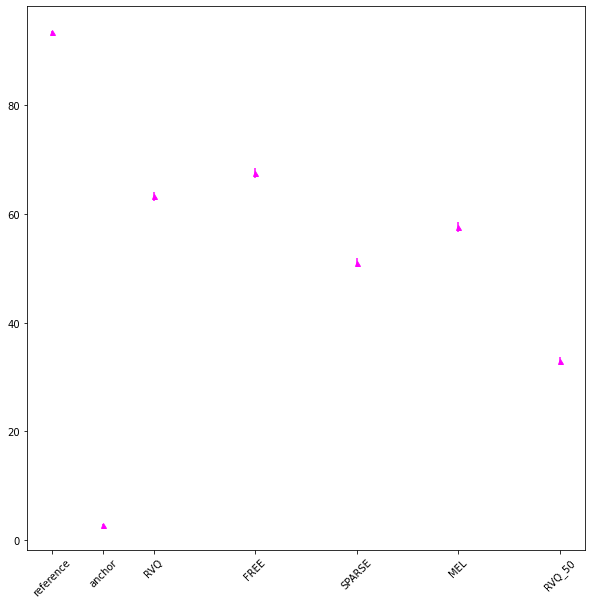

In [14]:
fig,ax = plt.subplots(1,figsize=(10,10))
p=0
pos = []
labels = []
means, stds = [],[]
for i,m in enumerate(Mdata.keys()):
    pos.append(p)
    labels.append(m)
    mean,std = np.array(Mdata[m]['score']).mean(),np.array(Mdata[m]['score']).std()/np.sqrt(len(Mdata[m]['score']))
    means.append(mean)
    stds.append(std)
    print(m,mean,std)
    if i in [0,1]:
        p += 0.5
    else:
        p +=1

ax.errorbar(pos,means,yerr = stds,linestyle = "none",markersize = 5,marker = '^',color = 'magenta')

ax.set_xticks(pos)
ax.set_xticklabels(labels, rotation=45)

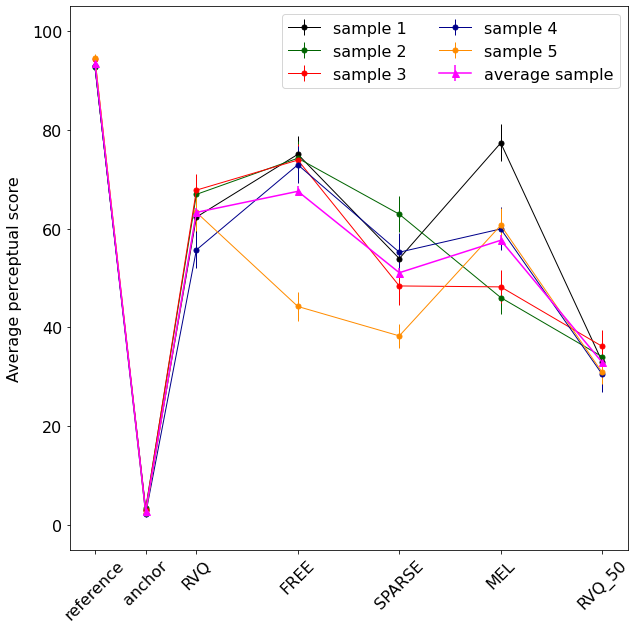

In [15]:
fig,ax = plt.subplots(1,figsize=(10,10))
fs = 16

colors = ["k","darkgreen","r","darkblue","darkorange"]
for IND,s in enumerate(adata.keys()):
    sample_data = adata[s]
    p=0
    pos = []
    labels = []
    mean_s = []
    std_s =[]
    for i,m in enumerate(sample_data.keys()):
        pos.append(p)
        labels.append(m)
        n_ratings = len(sample_data[m]['score'])
        mean,std = np.array(sample_data[m]['score']).mean(),np.array(sample_data[m]['score']).std()
        mean_s.append(mean)
        std_s.append(1.96*std/np.sqrt(n_ratings))
        if i in [0,1]:
            p += 0.5
        else:
            p +=1
            
    ax.errorbar(pos,mean_s,yerr = std_s,linestyle = "-",linewidth=1,color = colors[IND],markersize = 10,marker = '.',label=f"sample {IND+1}")

ax.errorbar(pos,means,yerr = stds,linestyle = "-",markersize = 7,marker = '^',color = 'magenta',label="average sample")
ax.set_xticks(pos)
ax.set_xticklabels(labels, rotation=45,fontsize = fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.set_ylim([-5,105])
ax.set_ylabel('Average perceptual score',fontsize=fs,labelpad = 10)
ax.legend(ncol = 2,fontsize = fs)
#plt.savefig(f'images/ratings.svg',transparent = True)

reference 93.49253731343283 0.20293994228311904
anchor 2.8276797829036635 0.12427695240232824
RVQ 63.284424379232505 0.8507557863262021
FREE 67.54691075514874 0.9769218513465592
SPARSE 51.075 0.9100521196817192
MEL 57.63844393592677 0.9691416573766586
RVQ_50 32.93392070484582 0.6955541805669084


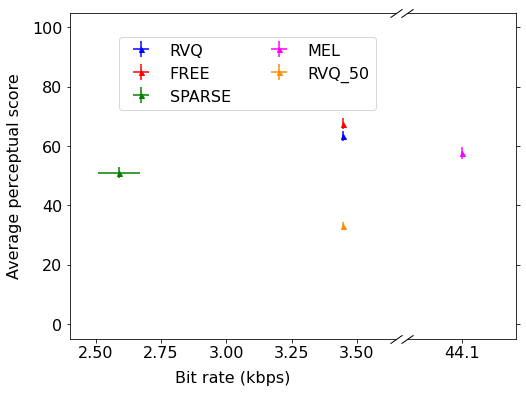

In [17]:
#Basic bit rate vs score
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8,6),sharey = True,gridspec_kw={'width_ratios': [3,1]})
labels = []
means, stds = [],[]
fs = 16
bit_rates = [3.445,3.445, 2.59,44.1,3.445]
s_bit_rates = [0,0, 0.08,0,0]

for i,m in enumerate(Mdata.keys()):
    pos.append(p)
    labels.append(m)
    mean,std = np.array(Mdata[m]['score']).mean(),np.array(Mdata[m]['score']).std()/np.sqrt(len(Mdata[m]['score']))
    means.append(mean)
    stds.append(1.96*std)
    print(m,mean,std)

colors = ['b','r','g','magenta','darkorange']
for i in range(len(bit_rates)):  
    for a in [ax,ax2]:
        a.errorbar(bit_rates[i],means[2:][i],yerr = stds[2:][i],xerr = s_bit_rates[i],
                    linestyle = "none",
                    markersize = 5,
                    marker = '^',
                    label = labels[2:][i],
                    color = colors[i])

ax.xaxis.set_tick_params(labelsize =fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax2.xaxis.set_tick_params(labelsize =fs)
ax2.yaxis.set_tick_params(labelsize=fs)
ax2.yaxis.set_tick_params(labelsize=fs)
ax2.set_xlim([43.9,44.3])
ax.set_xlim([2.4,3.65])

ax.set_ylim([-5,105])
ax.set_ylabel('Average perceptual score',fontsize=fs,labelpad = 10)
ax.set_xlabel('Bit rate (kbps)',fontsize=fs,labelpad = 10)
ax2.spines.left.set_visible(False)
ax.spines.right.set_visible(False)

ax2.yaxis.tick_right()
ax2.set_xticks([44.1])


d = 0.7
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([1, 1], [0, 1], transform=ax.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

ax.legend(ncol = 2,fontsize = fs,loc = [0.15,.7])
fig.subplots_adjust(wspace=0.05)
plt.savefig(f'images/ratings_vs_bitrate.svg',transparent = True)